## Gene Ontology Analysis

This notebook reproduces Fig. 2

Authors: Anna Ida Trolle and Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.patches import Patch
from scipy import stats
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import obonet
import time
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

from statsmodels.stats.nonparametric import rank_compare_2indep
    
def map_to_curated_codes(graph, GO_terms, curated_GO_codes, nodes):
    new_codes = np.empty(0)
    for code in GO_terms:
        if code in nodes and code != 'unknown':
            ancestors = list(nx.dfs_predecessors(graph, source=code, depth_limit=None).values())
            ancestors += list(nx.dfs_predecessors(graph, source=code, depth_limit=None).keys())
            intersect = np.intersect1d(ancestors, curated_GO_codes)
            if intersect.size==0:
                intersect = np.append(intersect, 'other')
            new_codes = np.append(new_codes, intersect)
    return np.unique(new_codes).tolist()

def calc_dof(x,y):
    nx = x.size
    ny = y.size
    rankc = stats.rankdata(np.concatenate((x,y)))
    rankcx = rankc[0:nx]
    rankcy = rankc[nx:nx+ny]
    rankcx_mean = np.mean(rankcx)
    rankcy_mean = np.mean(rankcy)
    rankx = stats.rankdata(x)
    ranky = stats.rankdata(y)
    rankx_mean = np.mean(rankx)
    ranky_mean = np.mean(ranky)

    Sx = np.sum(np.power(rankcx - rankx - rankcx_mean + rankx_mean, 2.0))
    Sx /= nx - 1
    Sy = np.sum(np.power(rankcy - ranky - rankcy_mean + ranky_mean, 2.0))
    Sy /= ny - 1

    df_numer = np.power(nx * Sx + ny * Sy, 2.0)
    df_denom = np.power(nx * Sx, 2.0) / (nx - 1)
    df_denom += np.power(ny * Sy, 2.0) / (ny - 1)
    return df_numer / df_denom

def bootstrap(a,b,n_bootstrap,subsample=False):
    cohens_d = (a.mean()-b.mean()) / np.sqrt(0.5*(a.std()**2+b.std()**2))
    alternative = 'greater' if cohens_d > 0 else 'less'
    a_picked_size = a.size
    b_picked_size = a_picked_size if subsample else b.size
    cohen_d_b = np.empty(0)
    W_BM_b = np.empty(0)
    for _ in range(n_bootstrap):
        a_p = np.random.choice(a,size=a_picked_size)
        b_p = np.random.choice(b,size=b_picked_size)
        cohen_d_b = np.append(cohen_d_b, (a_p.mean()-b_p.mean()) / np.sqrt(0.5*(a_p.std()**2+b_p.std()**2)))
        W_BM_b = np.append(W_BM_b, stats.brunnermunzel(a_p, b_p)[0])
    if cohens_d > 0:
        pvalue_b = np.sum(W_BM_b>=0) / n_bootstrap
    else:
        pvalue_b = np.sum(W_BM_b<=0) / n_bootstrap
    return cohens_d, np.std(cohen_d_b), pvalue_b

def populate_table(df,a,b,prop,pvalue,name,n_bootstrap,subsample=False):
    sub = '_sub'
    if not subsample:
        sub = ''
        df.loc[name,prop+'_p'] = pvalue
        if df.loc[name,prop+'_p'] < 1e-5:
            df.loc[name,prop+'_p_excel'] = f'<{1e-5:.1g}'
        else:
            df.loc[name,prop+'_p_excel'] = f'{pvalue:.1g}'
    cohens_d, cohens_d_se, pvalue_b = bootstrap(a,b,n_bootstrap,subsample)
    df.loc[name,prop+'_cd'+sub] = cohens_d
    df.loc[name,prop+'_cd_se'+sub] = cohens_d_se
    df.loc[name,prop+'_p'] = pvalue
    df.loc[name,prop+'_p_b'+sub] = pvalue_b
    df.loc[name,prop+'_cd_excel'+sub] = f'{cohens_d:.2f}±{cohens_d_se:.2f}'
    if df.loc[name,prop+'_p_b'+sub] < 1/n_bootstrap:
        df.loc[name,prop+'_p_b_excel'+sub] = f'<{1/n_bootstrap:.1g}'
    else:
        df.loc[name,prop+'_p_b_excel'+sub] = f'{pvalue_b:.1g}'
    
def generate_stats_csv(df_idrome,prop_nu,prop_SPR,GO_dict,nodes_cat,label):
    # Copy dict of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
    GO_terms = GO_dict.copy() 
    # Copy database
    df_GO = df_idrome.copy()
        
    g,u = np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum(),return_counts=True)
    curated_GO_codes = g[u>=200]
    curated_GO_codes = np.unique(np.intersect1d(curated_GO_codes,nodes_cat))
    curated_GO_terms = [id_to_name[x] for x in curated_GO_codes]
    GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, nodes_cat) )

    df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
    df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
    df_GO = df_GO[df_GO['count_GO_terms']>0]
    df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
        lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
    df_GO.drop('count_GO_terms',axis=1,inplace=True)
    
    print(df_GO.shape[0])
    
    statistics = pd.DataFrame(index=curated_GO_terms)
    n_bootstrap = 100000
    for name in curated_GO_terms:
        bool_term = df_GO.GO_terms.apply(lambda x : name in x).values
        p_nu = stats.brunnermunzel(df_GO[bool_term][prop_nu], 
                        df_GO[~bool_term][prop_nu], alternative='two-sided')[1]/2   
        p_SPR = stats.brunnermunzel(df_GO[bool_term][prop_SPR], 
                        df_GO[~bool_term][prop_SPR], alternative='two-sided')[1]/2
        if p_nu<=1e-5 or p_SPR<=1e-5:
            print(name)
            t0 = time.time()
            for prop,pvalue in zip([prop_nu,prop_SPR],[p_nu,p_SPR]):
                populate_table(statistics,df_GO[bool_term][prop].values, 
                        df_GO[~bool_term][prop].values,prop,pvalue,name,n_bootstrap,subsample=False)
                populate_table(statistics,df_GO[bool_term][prop].values, 
                        df_GO[~bool_term][prop].values,prop,pvalue,name,n_bootstrap,subsample=True)
            print('{:.3f} s'.format(time.time()-t0))
            
    statistics = statistics.sort_values(by=prop_nu+'_p')
    statistics.to_csv(f'go_analysis/GO_stats_{label:s}.csv')
    return df_GO

In [14]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

#### Load basic version of the GO

In [2]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

#### Get nodes connected to molecular function, biological process, and cellular component

In [3]:
print(name_to_id['molecular_function'],name_to_id['biological_process'],name_to_id['cellular_component'])
molfunc = list(nx.ancestors(graph, 'GO:0003674')) # all nodes connected to molecular function
bioproc = list(nx.ancestors(graph, 'GO:0008150')) # all nodes connected to biological process
cellcom = list(nx.ancestors(graph, 'GO:0005575')) # all nodes connected to cellular component

GO:0003674 GO:0008150 GO:0005575


# Brunner Munzel Test on $\nu$ and $S_\text{conf}$ Distributions

In [ ]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
GO_dict = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
df_GO_molfunc = generate_stats_csv(df_idrome,'nu','SPR',GO_dict,molfunc,'molfunc')
df_GO_cellcom = generate_stats_csv(df_idrome,'nu','SPR',GO_dict,cellcom,'cellcom')

df_GO_molfunc.to_pickle('go_analysis/df_GO_molfunc.pkl')
df_GO_cellcom.to_pickle('go_analysis/df_GO_cellcom.pkl')

In [ ]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome = df_idrome.query('fdomain == 0')
GO_dict = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
_ = generate_stats_csv(df_idrome,'nu','SPR',GO_dict,molfunc,'molfunc_no_domains')
_ = generate_stats_csv(df_idrome,'nu','SPR',GO_dict,cellcom,'cellcom_no_domains')

In [ ]:
df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)
GO_dict_spot = pd.Series(pd.read_pickle('go_analysis/uniprot_dict_SPOT.pkl')).to_frame(name='GO')
_ = generate_stats_csv(df_idrome_spot,'nu_svr','SPR_svr',GO_dict_spot,molfunc,'molfunc_spot')
_ = generate_stats_csv(df_idrome_spot,'nu_svr','SPR_svr',GO_dict_spot,cellcom,'cellcom_spot')

In [4]:
df_GO_molfunc = pd.read_pickle('go_analysis/df_GO_molfunc.pkl')
df_GO_cellcom = pd.read_pickle('go_analysis/df_GO_cellcom.pkl')

#### Excel Sheets

In [5]:
writer = pd.ExcelWriter('../Supplementary_Table_1.xlsx', engine='xlsxwriter')
#################
df_molfunc = pd.read_csv('go_analysis/GO_stats_molfunc.csv',index_col=0)
df_molfunc.nu_p_excel = df_molfunc.nu_p.apply(lambda x: f'{x:.1g}')
df_molfunc.SPR_p_excel = df_molfunc.SPR_p.apply(lambda x: f'{x:.1g}')
df_molfunc_no_domains = pd.read_csv('go_analysis/GO_stats_molfunc_no_domains.csv',index_col=0)
df_molfunc_no_domains.nu_p_excel = df_molfunc_no_domains.nu_p.apply(lambda x: f'{x:.1g}')
df_molfunc_no_domains.SPR_p_excel = df_molfunc_no_domains.SPR_p.apply(lambda x: f'{x:.1g}')
df_molfunc_spot = pd.read_csv('go_analysis/GO_stats_molfunc_spot.csv',index_col=0)
df_molfunc_spot.nu_svr_p_excel = df_molfunc_spot.nu_svr_p.apply(lambda x: f'{x:.1g}')
df_molfunc_spot.SPR_svr_p_excel = df_molfunc_spot.SPR_svr_p.apply(lambda x: f'{x:.1g}')
df_molfunc_all = df_molfunc[['nu_p','nu_p_excel','SPR_p_excel']].join(
                 df_molfunc_no_domains[['nu_p','nu_p_excel','SPR_p_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_molfunc_spot.columns = df_molfunc_spot.columns.map(lambda x: str(x) + '_SPOT')
df_molfunc_all = df_molfunc_all.join(
                 df_molfunc_spot[['nu_svr_p_SPOT','nu_svr_p_excel_SPOT','SPR_svr_p_excel_SPOT']],how='outer')
df_molfunc_all = df_molfunc_all.sort_values('nu_p_pLDDT')
df_molfunc_all = df_molfunc_all.dropna()
df_molfunc_all.drop(['nu_p_pLDDT','nu_p_nodomain','nu_svr_p_SPOT'],axis=1,inplace=True)
df_molfunc_all.to_excel(writer, 
    sheet_name='molecular functions, p-values')
#################
df_molfunc = pd.read_csv('go_analysis/GO_stats_molfunc.csv',index_col=0)
df_molfunc_no_domains = pd.read_csv('go_analysis/GO_stats_molfunc_no_domains.csv',index_col=0)
df_molfunc_spot = pd.read_csv('go_analysis/GO_stats_molfunc_spot.csv',index_col=0)
df_molfunc_all = df_molfunc[['nu_p','nu_cd_excel','SPR_cd_excel']].join(
                 df_molfunc_no_domains[['nu_cd_excel','SPR_cd_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_molfunc_spot.columns = df_molfunc_spot.columns.map(lambda x: str(x) + '_SPOT')
df_molfunc_all = df_molfunc_all.join(
                 df_molfunc_spot[['nu_svr_cd_excel_SPOT','SPR_svr_cd_excel_SPOT']],how='outer')
df_molfunc_all = df_molfunc_all.sort_values('nu_p')
df_molfunc_all = df_molfunc_all.dropna()
df_molfunc_all.drop('nu_p',axis=1,inplace=True)
df_molfunc_all.to_excel(writer, 
    sheet_name="cohen's d")
#################
df_molfunc = pd.read_csv('go_analysis/GO_stats_molfunc.csv',index_col=0)
df_molfunc_no_domains = pd.read_csv('go_analysis/GO_stats_molfunc_no_domains.csv',index_col=0)
df_molfunc_spot = pd.read_csv('go_analysis/GO_stats_molfunc_spot.csv',index_col=0)
df_molfunc_all = df_molfunc[['nu_p','nu_p_b_excel','SPR_p_b_excel']].join(
                 df_molfunc_no_domains[['nu_p_b_excel','SPR_p_b_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_molfunc_spot.columns = df_molfunc_spot.columns.map(lambda x: str(x) + '_SPOT')
df_molfunc_all = df_molfunc_all.join(
                 df_molfunc_spot[['nu_svr_p_b_excel_SPOT','SPR_svr_p_b_excel_SPOT']],how='outer')
df_molfunc_all = df_molfunc_all.sort_values('nu_p')
df_molfunc_all = df_molfunc_all.dropna()
df_molfunc_all.drop('nu_p',axis=1,inplace=True)
df_molfunc_all.to_excel(writer, 
    sheet_name='p-values (bootstrap)')
#################
df_molfunc = pd.read_csv('go_analysis/GO_stats_molfunc.csv',index_col=0)
df_molfunc_no_domains = pd.read_csv('go_analysis/GO_stats_molfunc_no_domains.csv',index_col=0)
df_molfunc_spot = pd.read_csv('go_analysis/GO_stats_molfunc_spot.csv',index_col=0)
df_molfunc_all = df_molfunc[['nu_p','nu_p_b_excel_sub','SPR_p_b_excel_sub']].join(
                 df_molfunc_no_domains[['nu_p_b_excel_sub','SPR_p_b_excel_sub']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_molfunc_spot.columns = df_molfunc_spot.columns.map(lambda x: str(x) + '_SPOT')
df_molfunc_all = df_molfunc_all.join(
                 df_molfunc_spot[['nu_svr_p_b_excel_sub_SPOT','SPR_svr_p_b_excel_sub_SPOT']],how='outer')
df_molfunc_all = df_molfunc_all.sort_values('nu_p')
df_molfunc_all = df_molfunc_all.dropna()
df_molfunc_all.drop('nu_p',axis=1,inplace=True)
df_molfunc_all.to_excel(writer, 
    sheet_name='p-values (subsampling)')
writer.save()
#################
writer = pd.ExcelWriter('../Supplementary_Table_2.xlsx', engine='xlsxwriter')
#################
df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
df_cellcom.nu_p_excel = df_cellcom.nu_p.apply(lambda x: f'{x:.1g}')
df_cellcom.SPR_p_excel = df_cellcom.SPR_p.apply(lambda x: f'{x:.1g}')
df_cellcom_no_domains = pd.read_csv('go_analysis/GO_stats_cellcom_no_domains.csv',index_col=0)
df_cellcom_no_domains.nu_p_excel = df_cellcom_no_domains.nu_p.apply(lambda x: f'{x:.1g}')
df_cellcom_no_domains.SPR_p_excel = df_cellcom_no_domains.SPR_p.apply(lambda x: f'{x:.1g}')
df_cellcom_spot = pd.read_csv('go_analysis/GO_stats_cellcom_spot.csv',index_col=0)
df_cellcom_spot.nu_svr_p_excel = df_cellcom_spot.nu_svr_p.apply(lambda x: f'{x:.1g}')
df_cellcom_spot.SPR_svr_p_excel = df_cellcom_spot.SPR_svr_p.apply(lambda x: f'{x:.1g}')
df_cellcom_all = df_cellcom[['nu_p','nu_p_excel','SPR_p_excel']].join(
                 df_cellcom_no_domains[['nu_p','nu_p_excel','SPR_p_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_cellcom_spot.columns = df_cellcom_spot.columns.map(lambda x: str(x) + '_SPOT')
df_cellcom_all = df_cellcom_all.join(
                 df_cellcom_spot[['nu_svr_p_SPOT','nu_svr_p_excel_SPOT','SPR_svr_p_excel_SPOT']],how='outer')
df_cellcom_all = df_cellcom_all.sort_values('nu_p_pLDDT')
df_cellcom_all = df_cellcom_all.dropna()
df_cellcom_all.drop(['nu_p_pLDDT','nu_p_nodomain','nu_svr_p_SPOT'],axis=1,inplace=True)
df_cellcom_all.to_excel(writer, 
    sheet_name='cell compartments, p-values')
#################
df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
df_cellcom_no_domains = pd.read_csv('go_analysis/GO_stats_cellcom_no_domains.csv',index_col=0)
df_cellcom_spot = pd.read_csv('go_analysis/GO_stats_cellcom_spot.csv',index_col=0)
df_cellcom_all = df_cellcom[['nu_p','nu_cd_excel','SPR_cd_excel']].join(
                 df_cellcom_no_domains[['nu_cd_excel','SPR_cd_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_cellcom_spot.columns = df_cellcom_spot.columns.map(lambda x: str(x) + '_SPOT')
df_cellcom_all = df_cellcom_all.join(
                 df_cellcom_spot[['nu_svr_cd_excel_SPOT','SPR_svr_cd_excel_SPOT']],how='outer')
df_cellcom_all = df_cellcom_all.sort_values('nu_p')
df_cellcom_all = df_cellcom_all.dropna()
df_cellcom_all.drop('nu_p',axis=1,inplace=True)
df_cellcom_all.to_excel(writer, 
    sheet_name="cell compartments, cohen's d")
#################
df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
df_cellcom_no_domains = pd.read_csv('go_analysis/GO_stats_cellcom_no_domains.csv',index_col=0)
df_cellcom_spot = pd.read_csv('go_analysis/GO_stats_cellcom_spot.csv',index_col=0)
df_cellcom_all = df_cellcom[['nu_p','nu_p_b_excel','SPR_p_b_excel']].join(
                 df_cellcom_no_domains[['nu_p_b_excel','SPR_p_b_excel']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_cellcom_spot.columns = df_cellcom_spot.columns.map(lambda x: str(x) + '_SPOT')
df_cellcom_all = df_cellcom_all.join(
                 df_cellcom_spot[['nu_svr_p_b_excel_SPOT','SPR_svr_p_b_excel_SPOT']],how='outer')
df_cellcom_all = df_cellcom_all.sort_values('nu_p')
df_cellcom_all = df_cellcom_all.dropna()
df_cellcom_all.drop('nu_p',axis=1,inplace=True)
df_cellcom_all.to_excel(writer, 
    sheet_name='p-values (bootstrap)')
#################
df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
df_cellcom_no_domains = pd.read_csv('go_analysis/GO_stats_cellcom_no_domains.csv',index_col=0)
df_cellcom_spot = pd.read_csv('go_analysis/GO_stats_cellcom_spot.csv',index_col=0)
df_cellcom_all = df_cellcom[['nu_p','nu_p_b_excel_sub','SPR_p_b_excel_sub']].join(
                 df_cellcom_no_domains[['nu_p_b_excel_sub','SPR_p_b_excel_sub']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_cellcom_spot.columns = df_cellcom_spot.columns.map(lambda x: str(x) + '_SPOT')
df_cellcom_all = df_cellcom_all.join(
                 df_cellcom_spot[['nu_svr_p_b_excel_sub_SPOT','SPR_svr_p_b_excel_sub_SPOT']],how='outer')
df_cellcom_all = df_cellcom_all.sort_values('nu_p')
df_cellcom_all = df_cellcom_all.dropna()
df_cellcom_all.drop('nu_p',axis=1,inplace=True)
df_cellcom_all.to_excel(writer, 
    sheet_name='p-values (subsampling)')
writer.save()

#### Fig. 2a

transcription cis-regulatory region binding: -0.22±0.02 vs -0.22
G protein-coupled receptor activity: 0.15±0.03 vs 0.14
chromatin binding: -0.16±0.03 vs -0.18
GTP binding: 0.22±0.07 vs 0.23


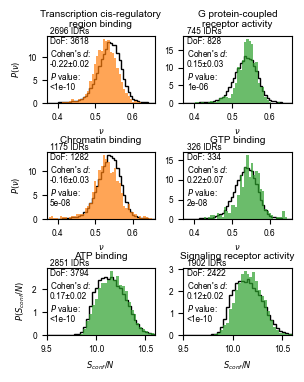

In [9]:
f, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(3,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

df_molfunc = pd.read_csv('go_analysis/GO_stats_molfunc.csv',index_col=0)
df_molfunc.nu_p_excel = df_molfunc.nu_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')
df_molfunc.SPR_p_excel = df_molfunc.SPR_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['transcription cis-regulatory region binding','G protein-coupled receptor activity',
                    'chromatin binding','GTP binding'],axes.flatten()):
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values
    
    a = df_GO_molfunc[bool_term].nu
    b = df_GO_molfunc[~bool_term].nu
    
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
        
    h = np.histogram(a,bins=bins,density=True)[0]
        
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = 'tab:green'
    if a.mean() < b.mean():
        alternative = 'less'
        color = 'tab:orange'
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)

    cohens_d_str = df_molfunc.loc[name,'nu_cd_excel']
    pvalue_str = df_molfunc.loc[name,'nu_p_excel']
        
    print(name+':',cohens_d_str, 'vs', round( 
        (np.mean(a)-np.mean(b)) / np.std(np.append(a-np.mean(a),b-np.mean(b))) ,2) )
    dof = f'\nDoF: {calc_dof(a,b):.0f}'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color,
          label=f'{N_IDRs:d} IDRs'+dof+"\nCohen's $d$:\n"+cohens_d_str+f'\n$P$ value:\n'+pvalue_str)
    
    if name == 'transcription cis-regulatory region binding':
        ax.set_title('Transcription cis-regulatory\nregion binding')
    elif name == 'GTP binding':
        ax.set_title('GTP binding')
    elif name == 'chromatin binding':
        ax.set_title('Chromatin binding')
    elif name == 'G protein-coupled receptor activity':
        ax.set_title('G protein-coupled\nreceptor activity')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(.37,.66)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.03,.16))
    legend.get_title().set_ha('center')  
    
bin_width = .03
bins = np.arange(9.3, 11.5,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['ATP binding',
                    'signaling receptor activity'],axes.flatten()[-2:]):
    
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values
    
    a = df_GO_molfunc[bool_term].SPR
    b = df_GO_molfunc[~bool_term].SPR
    
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
    
    h = np.histogram(a,bins=bins,density=True)[0]
        
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = 'tab:green'
    if a.mean() < b.mean():
        alternative = 'less'
        color = 'tab:orange'
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)
    
    cohens_d_str = df_molfunc.loc[name,'SPR_cd_excel']
    pvalue_str = df_molfunc.loc[name,'SPR_p_excel']
        
    dof = f'\nDoF: {calc_dof(a,b):.0f}'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color,
          label=f'{N_IDRs:d} IDRs'+dof+"\nCohen's $d$:\n"+cohens_d_str+f'\n$P$ value:\n'+pvalue_str)
    
    if name == 'ATP binding':
        ax.set_title('ATP binding')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(9.5,10.6)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.03,.16))
    legend.get_title().set_ha('center')    
    
for ax in axes[:2,:].flatten():
    ax.set_xlabel('$\\nu$')
for ax in axes[:2,0]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[-1,:]:
    ax.set_xlabel('$S_{conf}/N$')
for ax in axes[-1:,0]:
    ax.set_ylabel('$P(S_{conf}/N)$')    
    
plt.tight_layout(h_pad=0)
plt.savefig('figs/fig2a.pdf')
plt.show()

#### Fig. 2b

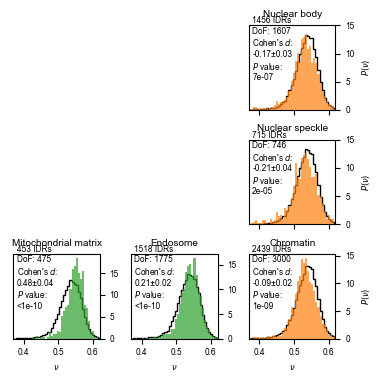

In [10]:
f, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(3.8,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
df_cellcom.nu_p_excel = df_cellcom.nu_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')
df_cellcom.SPR_p_excel = df_cellcom.SPR_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,i in zip(['nuclear body','nuclear speck','mitochondrial matrix','endosome','chromatin'],[2,5,6,7,8]):
    ax = axes.flatten()[i]
    bool_term = df_GO_cellcom.GO_terms.apply(lambda x : name in x).values
    
    a = df_GO_cellcom[bool_term].nu
    b = df_GO_cellcom[~bool_term].nu
    
    h_1 = np.histogram(a,bins=bins,density=True)[0]
    h_2 = np.histogram(b,bins=bins,density=True)[0]
    
    N_IDRs = df_GO_cellcom[bool_term].shape[0]
    
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = 'tab:green'
    if a.mean() < b.mean():
        alternative = 'less'
        color = 'tab:orange'
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)

    cohens_d_str = df_cellcom.loc[name,'nu_cd_excel']
    pvalue_str = df_cellcom.loc[name,'nu_p_excel']
    
    dof = f'\nDoF: {calc_dof(a,b):.0f}'
    
    ax.bar(x,h_1,alpha=.7,width=bin_width,color=color,
          label=f'{N_IDRs:d} IDRs'+dof+"\nCohen's $d$:\n"+cohens_d_str+f'\n$P$ value:\n'+pvalue_str)
    
    if name in ['nuclear body','nuclear speck']:
        ax.set_ylim(0,15)

    if name == 'nuclear speck':
        name = 'nuclear speckle'
    
    ax.set_title(name.capitalize())

    ax.set_xlim(.37,.62)
    ax.set_xticks([.4,.5,.6])
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.04,.33))

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
for ax in axes[-1,:]:
    ax.set_xlabel('$\\nu$')
for ax in axes[:,2]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[:2,:2].flatten():
    ax.axis('off')
plt.tight_layout()
plt.savefig('figs/fig2b.pdf')
plt.show()

#### Searching for TFs analysed by Staller et al. (DOI: https://doi.org/10.1016/j.cels.2022.01.002)

In [11]:
dataset_3 = pd.read_csv('https://ars.els-cdn.com/content/image/1-s2.0-S2405471222000023-mmc4.csv',
           storage_options={'User-Agent': 'Mozilla/5.0'},index_col=2)

tfs_staller = []

df_staller = df_GO_molfunc[df_GO_molfunc.UniProt_ID.apply(lambda x: x[0]).isin(dataset_3.index)]
bool_term = df_staller.GO_terms.apply(lambda x : 'transcription cis-regulatory region binding' in x).values
df_staller = df_staller[bool_term].query('nu <= 0.475')
for idr in df_staller.index:
    if type(dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq) == str:
        if dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq in df_staller.loc[idr].fasta:
            print(df_staller.loc[idr].protein_name,df_staller.loc[idr].nu)
            tfs_staller.append(idr)
    else:
        for seq in dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq.values:
            if seq in df_staller.loc[idr].fasta:
                print(df_staller.loc[idr].protein_name,df_staller.loc[idr].nu)
                tfs_staller.append(idr)
print(np.unique(tfs_staller).size)

Forkhead box protein O6 0.455
Transcription factor SOX-11 0.474
Forkhead box protein O4 0.443
Zinc finger protein interacting with ribonucleoprotein K 0.472
Coiled-coil and C2 domain-containing protein 1A 0.438
Pancreas transcription factor 1 subunit alpha 0.401
Zinc finger and BTB domain-containing protein 46 0.456
Adipocyte enhancer-binding protein 1 0.438
Zinc finger protein 561 0.454
Zinc finger protein 473 0.439
HMG box transcription factor BBX 0.413
Zinc finger protein 419 0.464
Zinc finger protein 42 homolog 0.468
Homeobox protein ARX 0.41
ETS-related transcription factor Elf-4 0.448
Zinc finger protein 644 0.438
PR domain zinc finger protein 5 0.457
CXXC-type zinc finger protein 1 0.456
Zinc finger protein 639 0.465
Zinc finger protein 777 0.412
20


In [12]:
dataset_3 = pd.read_csv('https://ars.els-cdn.com/content/image/1-s2.0-S2405471222000023-mmc4.csv',
           storage_options={'User-Agent': 'Mozilla/5.0'},index_col=2)

tfs_staller = []

df_staller = df_GO_molfunc[df_GO_molfunc.UniProt_ID.apply(lambda x: x[0]).isin(dataset_3.index)]
for idr in df_staller.index:
    if type(dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq) == str:
        if dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq in df_staller.loc[idr].fasta:
            #print(df_staller.loc[idr].protein_name,df_staller.loc[idr].GO_terms)
            tfs_staller.append(idr)
    else:
        for seq in dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq.values:
            if seq in df_staller.loc[idr].fasta:
                #print(df_staller.loc[idr].protein_name,df_staller.loc[idr].GO_terms)
                tfs_staller.append(idr)
print(np.unique(tfs_staller).size)

107


#### Proteins with compact IDRs that localize in intracellular membraneless organelles

In [17]:
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
go_ids_mlos = [name_to_id[name] for name in ['intracellular non-membrane-bounded organelle']]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, go_ids_mlos, cellcom) )
nuc_mos = GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID][
    GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_mlos for i in x])>0).values].index.unique()
nuc_mos.size, 'intracellular non-membrane-bounded organelle'

(441, 'intracellular non-membrane-bounded organelle')

#### Proteins with compact IDRs that localize in nucleoli, nuclear speckles, nuclear bodies, and PML bodies

In [15]:
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
go_ids_nuclear_condensates = [name_to_id[name] for name in ['nucleolus','nuclear speck','nuclear body','PML body']]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, go_ids_nuclear_condensates, cellcom) )
nuc_mos = GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID][
    GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_nuclear_condensates for i in x])>0).values].index.unique()
nuc_mos.size, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body'

(224, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body')

#### Example: Find IDRs with a specific GO term

In [16]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)
# Map GO terms that have catalytic activity as parent term
curated_GO_codes = ['GO:0003824']
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, molfunc) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO['GO_terms'] = df_GO.GO_terms.apply(lambda x : 0 if x==['other'] else x[0])
df_GO.drop('count_GO_terms',axis=1,inplace=True)
df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: x[0])

df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome['is_enzyme'] = False
df_idrome.loc[df_GO.query('GO_terms != 0').index,'is_enzyme'] = True 

df_idrome.query('is_enzyme').protein_name

seq_name
A0A024RBG1_145_181    Diphosphoinositol polyphosphate phosphohydrola...
A0A0B4J2F2_350_783       Putative serine/threonine-protein kinase SIK1B
A0A0B4J2F2_278_307       Putative serine/threonine-protein kinase SIK1B
A0A0U1RR11_239_272                  Centromere protein V-like protein 1
A0A0U1RR11_1_90                     Centromere protein V-like protein 1
                                            ...                        
Q9Y6X9_576_795                                             ATPase MORC2
Q9Y6Y8_1_269                                  SEC23-interacting protein
Q9Y6Y8_595_653                                SEC23-interacting protein
Q9Y6Y8_709_773                                SEC23-interacting protein
Q9Y6Y8_853_947                                SEC23-interacting protein
Name: protein_name, Length: 6724, dtype: object